# Spatial Clustering Algorithm under MEmory Limits (SCAMEL) for Travel-Time Catchments: Illinois

**Author:** Alexander Michels

In this notebook, we will walk through the SCAMEL algorithm for calculating travel-time catchments of hospitals in Illinois.

In [1]:
from collections import Counter
import copy
from disjoint_set import DisjointSet
import geopandas as gpd
import itertools
import math
import matplotlib.pyplot as plt
import multiprocessing as mp
import networkx as nx
from networkx.algorithms.operators.binary import compose as nx_compose
from numbers import Number  # allows for type hinting of numerics
import numpy as np
import os
import pandas as pd
import time
import tqdm
from typing import Iterable, List, Set, Tuple

# Table of Contents:

* [Parameters](#params)
* [Data](#data)
* [Calculating Primary Regions](#primary)
* [Merging by Set Relations (Shared Spatial Context)](#set-rel)
* [Merging by Memory](#memory)

# Parameters

For simplicity, I have put the parameters/file paths/etc. in this big `PARAMS` dict. Not all of the parameters/options below are relevant, but they are all given because I used a large PARAM json when running my experiments.

A brief overview of the sections:

* access - parameters related to the accessibility calculation. You'll see projection to do the final plot in and weights to use for E2SFCA
* compute - computational parameters, specifically maximum memory and number of threads for certain sections that are parallelized
* graphml - parameters related to the OSMnx networks, stored in graphml files. Unfortunatly, Github doesn't allow for storing hundreds of gigabytes of graphml files, but the `scripts` folder can help you obtain the graphs yourself.
* output - used for configuring outputs like figure size
* pop - information relating to population data
* region - parameters relating to clustering regions and calculating travel-time catchments
* resource - parameters relating to the resource data (in our case hospitals

In [2]:
PARAMS = {
    "access": {
        "weights": [1.0, 0.68, 0.22],
        "projection": "EPSG:4326"
    },
    "compute": {
        "max_memory" : 8,
        "threads" : 8
    },
    "graphml": {
        "geo_unit_key" : "GEOID",
        "geo_unit_shapefile" : "../data/geodata/counties/ILCounties/ILCountyShapefile.shp",
        "dir" : "../data/graphml/ilcounties/graphml",
        "name_format" : "0500000US{}.graphml",
        "memory_csv" : "../data/memory_df/USCounty-MemoryUsage.csv",
        "memory_column" : "Memory Usage (GB)",
        "memory_key" : "GEOID"
    },
    "output": {
        "figsize": [12, 18]
    },
    "pop" : {
        "file": "../data/pop/illinois/SVI2018_IL_tract.shp",
        "pop_field": "E_TOTPOP",
        "pop_key": "FIPS"
    },
    "region" : {
        "batch_size": 4,
        "buffer": 64374,
        "catchment_file_pattern": "resource_catchments_{}distance.geojson",
        "catchment_how": "convexhull",
        "distances": [600, 1200, 1800],
        "dir": "../data/regions/Illinois",
        "projection" : "ESRI:102003"
    },
    "resource" : {
        "key": "ID",
        "resource": "BEDS",
        "shapefile" : "../data/hospitals/illinois/IllinoisHospitals.shp"
    }
}

<hr id="data">

# Data

Let's load the hospital data! We will also perform a few checks:

* check that our "key" is actually unique so we can identify each hospital uniquely
* project our data to Contiguous Albers Equal Area Conic Projection: https://epsg.io/102003
* print out the projection and number of hospitals
* view the data with head()

In [3]:
resources = gpd.read_file(PARAMS["resource"]["shapefile"])
assert resources[PARAMS["resource"]["key"]].is_unique
resources = resources.to_crs(PARAMS["region"]["projection"])
print("The geometry is {}".format(resources.crs))
print("There are {} resources represented".format(len(resources)))
resources.head()

The geometry is ESRI:102003
There are 226 resources represented


,OBJECTID,ID,NAME,ADDRESS,CITY,STATE,ZIP,ZIP4,TELEPHONE,TYPE,...,WEBSITE,STATE_ID,ALT_NAME,ST_FIPS,OWNER,TTL_STAFF,BEDS,TRAUMA,HELIPAD,geometry
0,1513,0003460644,UHS HARTGROVE HOSPITAL,5730 WEST ROOSEVELT ROAD,CHICAGO,IL,60644,NOT AVAILABLE,(773) 413-1700,PSYCHIATRIC,...,http://www.hartgrovehospital.com,0005454,NOT AVAILABLE,17,PROPRIETARY,-999,128,NOT AVAILABLE,N,POINT (677706.861 518544.822)
1,1514,0001860612,JESSE BROWN VA MEDICAL CENTER - VA CHICAGO HEA...,820 S DAMEN STREET,CHICAGO,IL,60612,NOT AVAILABLE,(312) 569-8387,MILITARY,...,http://www.chicago.va.gov/,14003F,NOT AVAILABLE,17,GOVERNMENT - FEDERAL,-999,240,NOT AVAILABLE,N,POINT (685088.436 519684.489)
2,1515,0003160463,PALOS COMMUNITY HOSPITAL,12251 SOUTH 80TH AVENUE,PALOS HEIGHTS,IL,60464,NOT AVAILABLE,(708) 923-4000,GENERAL ACUTE CARE,...,http://www.paloscommunityhospital.org,140062,NOT AVAILABLE,17,NON-PROFIT,-999,377,NOT AVAILABLE,Y,POINT (675828.819 496243.670)
3,1516,0003660628,ROSELAND COMMUNITY HOSPITAL,45 W 111TH STREET,CHICAGO,IL,60628,NOT AVAILABLE,(773) 995-3000,GENERAL ACUTE CARE,...,http://www.roselandhospital.org,140068,NOT AVAILABLE,17,NON-PROFIT,-999,115,NOT AVAILABLE,N,POINT (691089.739 500162.084)
4,1517,0002360302,WEST SUBURBAN MEDICAL CENTER,3 ERIE COURT,OAK PARK,IL,60302,NOT AVAILABLE,(708) 383-6200,GENERAL ACUTE CARE,...,http://www.westsuburbanmc.com/Home.aspx,140049,NOT AVAILABLE,17,PROPRIETARY,-999,172,NOT AVAILABLE,N,POINT (676748.773 521277.201)


We can also visualize the data by plotting it with Geopandas:

<AxesSubplot:>

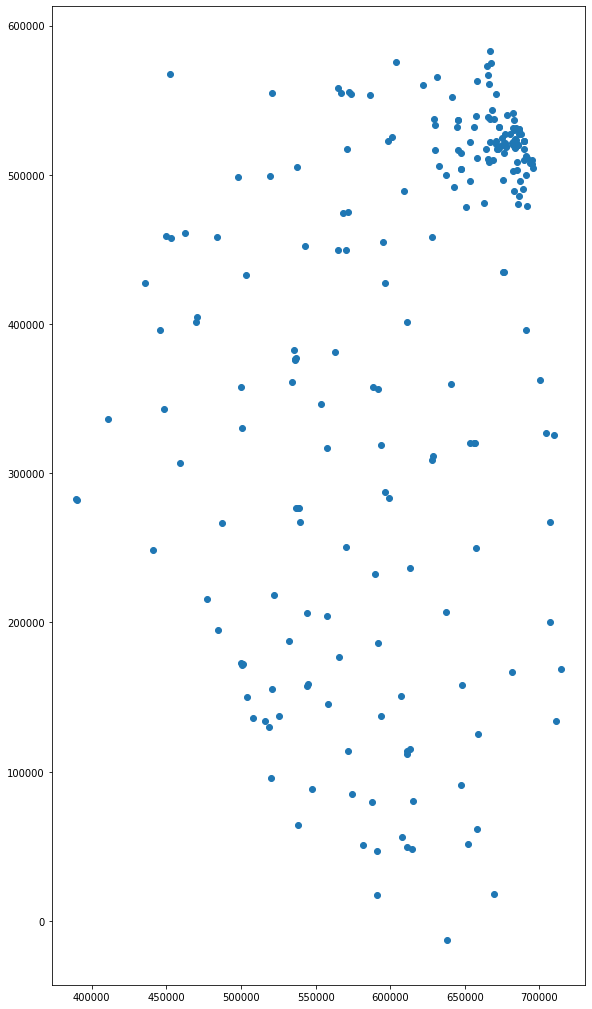

In [4]:
resources.plot(figsize=PARAMS["output"]["figsize"])

Our method for calculating travel-time catchments relies on clustering spatial units (in our case counties) together into "regions." Doing this requires that we have our OSMnx network pulled by county, and data on the geographic bounds of counties so we can see how they relate to our hospitals.

Here we load the shapefile for counties, drop any duplicates, and project the data.

In [5]:
county_shapefiles = gpd.read_file(PARAMS["graphml"]["geo_unit_shapefile"])
county_shapefiles.drop_duplicates(inplace=True, subset=[PARAMS["graphml"]["geo_unit_key"]])
county_shapefiles = county_shapefiles.to_crs(PARAMS["region"]["projection"])
print("There are {} counties represented".format(len(county_shapefiles)))
county_shapefiles.head()

There are 102 counties represented


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,17,091,00424247,0500000US17091,17091,Kankakee,06,1752121058,12440760,"POLYGON ((644807.679 431295.144, 645687.311 43..."
1,17,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((436783.276 363512.862, 436755.241 36..."
2,17,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((638438.260 499329.590, 638973.311 49..."
3,17,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((542119.643 147413.564, 543761.494 14..."
4,17,031,01784766,0500000US17031,17031,Cook,06,2447370818,1786313044,"POLYGON ((635130.213 537472.688, 635563.062 53..."


Let's plot the data with Geopandas again:

<AxesSubplot:>

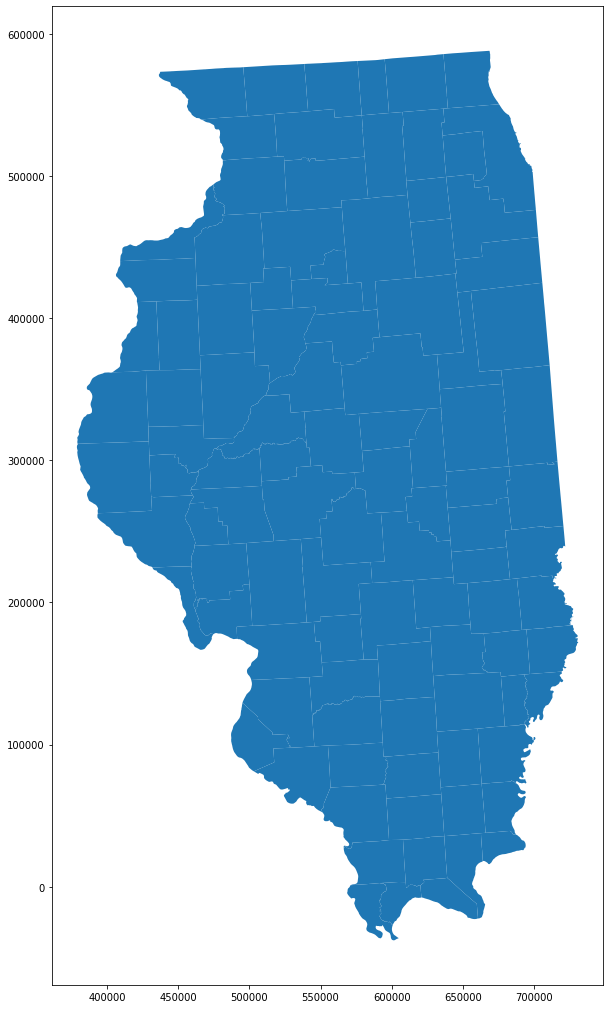

In [6]:
county_shapefiles.plot(figsize=PARAMS["output"]["figsize"])

Our method clusters the road network pieces up to a given memory limit. To do this, we need information on the memory usage of each piece of the network. This was generated with a script in the `scripts` directory if you're interested on the details!

In [7]:
memory_df = pd.read_csv(PARAMS["graphml"]["memory_csv"])
# cast ID to string
memory_df[PARAMS["graphml"]["memory_key"]] = memory_df[PARAMS["graphml"]["memory_key"]].astype(str)
# left pad the string with zeros up to 5 digits
memory_df[PARAMS["graphml"]["memory_key"]] = memory_df[PARAMS["graphml"]["memory_key"]].str.pad(5, side="left", fillchar="0")
print("There are {} counties represented".format(len(memory_df)))
memory_df.drop_duplicates(inplace=True, subset=[PARAMS["graphml"]["memory_key"]])
memory_df.head()

There are 3230 counties represented


,FGEOID,GEOID,NAME,NAMELSAD,GEOID_FILE,Memory Usage (GB)
0,0500000US31039,31039,Cuming,Cuming County,0500000US31039.graphml,0.030626
1,0500000US53069,53069,Wahkiakum,Wahkiakum County,0500000US53069.graphml,0.008176
2,0500000US35011,35011,De Baca,De Baca County,0500000US35011.graphml,0.051917
3,0500000US31109,31109,Lancaster,Lancaster County,0500000US31109.graphml,0.292643
4,0500000US31129,31129,Nuckolls,Nuckolls County,0500000US31129.graphml,0.026382


<hr id="primary">

# Calculate Primary Regions

This step uses an over-estimate of the driving-time catchment to determine the pieces of the network necessary for calculating each hospital's travel-time catchment. Since our projection is in meters, we set the buffer radius to ~64km whih is ~40miles. This will contain a 30 minute driving-time catchment even if the driver is going straight at 80mph for the entire 30 minutes.

Let's plot the buffers:

In [8]:
def calculate_buffers(gdf: gpd.GeoDataFrame, buffer: Number) -> gpd.GeoDataFrame:
    """
    Makes a deepcopy with geography replaced with buffers.

    Args:
        gdf: GeoDataFrame
        buffer: Number, size of the buffer (in gdf's CRS units)

    Returns:
        GeoDataFrame, copy of gdf with buffers in geometry
    """
    buffers = gdf.copy(deep=True)
    buffers["geometry"] = buffers.geometry.buffer(buffer)
    return buffers

<AxesSubplot:>

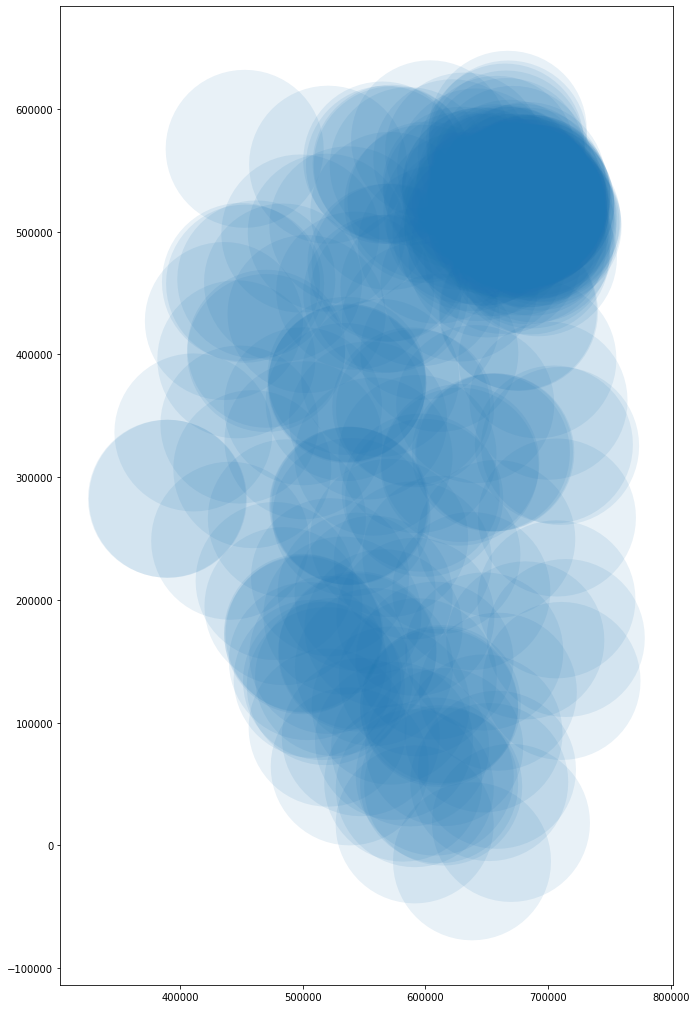

In [9]:
buffers = resources.copy(deep=True)
buffers = calculate_buffers(resources, PARAMS["region"]["buffer"])
buffers.plot(alpha=0.1, figsize=PARAMS["output"]["figsize"])

Using this information we can calculate the overlap between each hospital's buffer and the counties:

In [10]:
def calculate_primary_regions(resources: gpd.GeoDataFrame, resource_key: str, buffer_size: float,
                              spatial_units: gpd.GeoDataFrame, spatial_units_key: str,
                              disable_tqdm=False) -> dict:
    """
    For each shape in `buffers`, we calculate it's overlap with the shapes in `spatial_units`.

    Args:
        resources (gpd.GeoDataFrame): Geodataframe of resources (hospitals)
        resource_key (str): key/ID field for resources/buffers
        buffer_size (float): size of buffers for resources
        spatial_units (gpd.GeoDataFrame): Geodataframe of spatial units (counties)
        spatial_units_key (str): key/ID field for spatial_units
        disable_tqdm (bool): whether or not to disable the tqdm progress bar

    Returns:
        Dictionary of id -> set of keys from spatial_units

    Raises:
        Assertion that the length of each overlap list is greater than zero

    Todo:
        * Better error handling/checking for len >= 0
    """
    buffers = resources.copy(deep=True)
    buffers["geometry"] = buffers.geometry.buffer(buffer_size)
    # resource to spatial unit dict
    region2sudict = dict()
    for index, row in tqdm.tqdm(buffers.iterrows(), desc="Calculating primary regions", disable=disable_tqdm,
                                position=0, total=len(buffers)):
        in_buffer = spatial_units[spatial_units.intersects(row["geometry"])]
        _geoids = set(list(in_buffer[spatial_units_key]))
        region2sudict[row[resource_key]] = _geoids
    return copy.deepcopy(region2sudict)

In [11]:
resource_census_unit_overlap_dict = calculate_primary_regions(resources,
                                                              PARAMS["resource"]["key"],
                                                              PARAMS["region"]["buffer"],
                                                              county_shapefiles,
                                                              PARAMS["graphml"]["geo_unit_key"])
# resource_census_unit_overlap_dict

Calculating primary regions: 100%|█████████████████████████████████████████████████| 226/226 [00:00<00:00, 382.30it/s]


This dictionary can be extremely long, so let's look at a small slice of it:

In [12]:
dict(list(resource_census_unit_overlap_dict.items())[0:5])

{'0003460644': {'17031',
  '17043',
  '17063',
  '17089',
  '17091',
  '17093',
  '17097',
  '17111',
  '17197'},
 '0001860612': {'17031',
  '17043',
  '17089',
  '17091',
  '17093',
  '17097',
  '17111',
  '17197'},
 '0003160463': {'17031',
  '17043',
  '17063',
  '17089',
  '17091',
  '17093',
  '17097',
  '17111',
  '17197'},
 '0003660628': {'17031',
  '17043',
  '17063',
  '17089',
  '17091',
  '17093',
  '17097',
  '17197'},
 '0002360302': {'17031',
  '17043',
  '17063',
  '17089',
  '17093',
  '17097',
  '17111',
  '17197'}}

This method performs a *partitioning* of the hospitals (each hospital in one group) and *clustering* of the counties (counties can be in more than one group). After this step we have a partition of singletons meaning that each hospital is in a group by itself. This algorithm also gives us a one-to-one relationship between each partition of hospitals and cluster of counties where the group of counties is sufficient for calculating the travel-time catchments for the corresponding group of hospitals.

A county network will be loaded once for each cluster it is in. Let's visualize how many times each county network is loaded if we used this initial partition!

First we need to count how many times each county is included in a cluster and make that into a dataframe, then we can merge that to our geodataframe and plot:

In [13]:
def viz_nregions(region2sudict: dict, spatial_units: gpd.GeoDataFrame, su_key: str,
                 output_column: str = "nregions") -> gpd.GeoDataFrame:
    """
    Function for visualizing the number of regions each spatial unit is in at a given step of the
    process.

    Args:
        region2sudict: dict, maps regions to the census units that make up the region
        spatial_units: GeoDataFrame of spatial units
        su_key: str, key for the spatial_units GeoDataFrame
        output_column: str, column to write result to

    Returns:
        copy of spatial_units with `column` having the number of regions each spatial unit is in
    """
    region_counter = Counter()
    for region_id, geoids in region2sudict.items():
        for geoid in geoids:
            region_counter[geoid] += 1
    # convert counter to dataframe for merging
    region_df = pd.DataFrame(region_counter.items(), columns=[su_key, output_column])
    output_gdf = spatial_units.copy(deep=True)
    # drop our output column if it already exists
    output_gdf = output_gdf.drop(columns=output_column, errors='ignore')
    output_gdf = output_gdf.merge(region_df, how="left", on=su_key)
    return output_gdf

<AxesSubplot:>

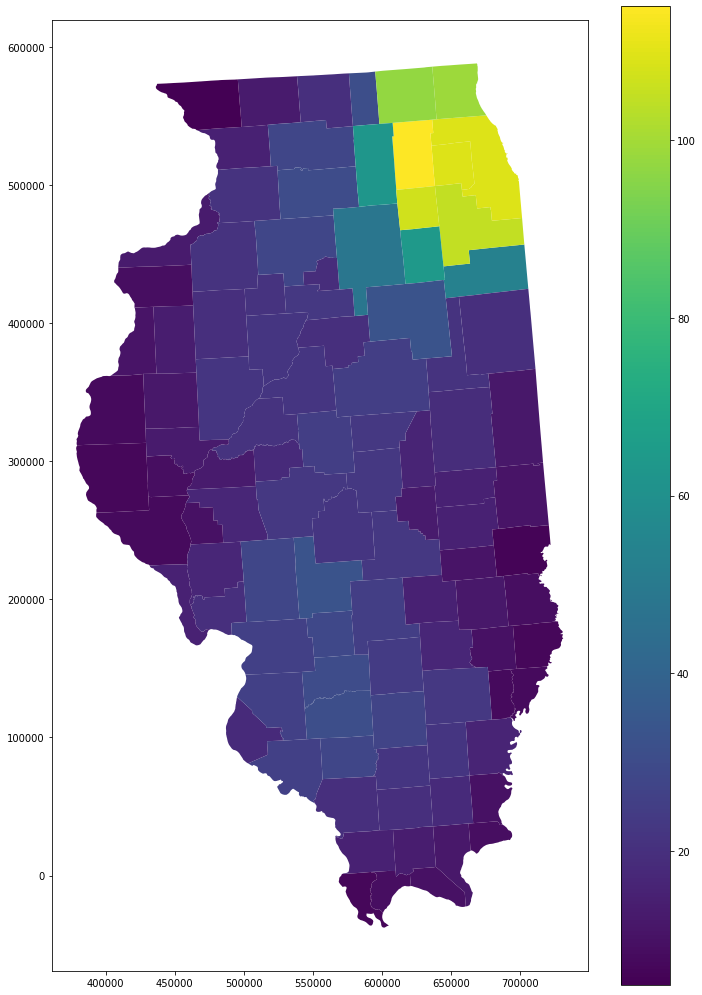

In [14]:
primary_regions = viz_nregions(resource_census_unit_overlap_dict, county_shapefiles,
                               PARAMS["graphml"]["geo_unit_key"])
primary_regions.plot(column='nregions', figsize=PARAMS["output"]["figsize"], legend=True)

<hr id="set-rel">

# Merging by Set Relations (Shared Spatial Context)

Now that we know the necessary counties for each hospital, we want to combine them by shared spatial context. Since we have the spatial context given by a list of counties, we can do this by just comparing the sets of counties. If $A\subseteq B$ which means "A is a subset of B", then A's list of counties are included in B's so we can do the travel-time calculation for A and B with B's set of counties! Note that this means these merges don't add to the memory requirements: B's counties would have to be loaded regardless, but calculating A and B together let's us avoid loading the counties twice.

Let's see what hospitals we should merge:

In [15]:
def calculate_secondary_regions(region2sudict: dict, resources: gpd.GeoDataFrame, 
                                resource_key: str) -> Tuple[dict, dict]:
    """
    Calculates the secondary regions by their set relations/shared spatial context.

    Args:
        region2sudict (dict): maps resources to the spatial units that make up their primary region
        resources (gpd.GeoDataFrame): GeoDataFrame of resources
        resource_key (str): key/ID in resources

    Returns:
        Tuple of dicts: updated region2sudict (region -> spatial units) and resource2regiondict
        (resource -> region)
    """
    _resources = list(resources[resource_key])
    resource_disjoint_set = DisjointSet()  # create a disjoint set
    for r in _resources:
        resource_disjoint_set.find(r)  # add the stuff to the disjoint set
    for key in tqdm.tqdm(_resources, desc="Merging by Set Rel", position=0):
        val = set(region2sudict[key])
        for okey in _resources:
            oval = set(region2sudict[okey])
            if val == oval:  # sets are same
                resource_disjoint_set.union(okey, key)
            elif oval.issubset(val):
                resource_disjoint_set.union(okey, key)
                unioned_region = region2sudict[key].union(region2sudict[okey])
                region2sudict[key] = unioned_region
                region2sudict[okey] = unioned_region
    # record map of resource to region (i.e. reverse of ds dictionary)
    newregion2sudict, resource2regiondict = dict(), dict()
    for key, val in tqdm.tqdm(resource_disjoint_set.itersets(with_canonical_elements=True),
                              desc="Updating maps", position=0):
        newregion2sudict[key] = region2sudict[key]
        for resource in val:
            resource2regiondict[resource] = key
    return newregion2sudict, resource2regiondict

In [16]:
region2cu, resource2region = calculate_secondary_regions(resource_census_unit_overlap_dict,
                                                         resources,
                                                         PARAMS["resource"]["key"])

Merging by Set Rel: 100%|█████████████████████████████████████████████████████████| 226/226 [00:00<00:00, 3863.53it/s]
Updating maps: 67it [00:00, 168073.19it/s]


In [17]:
# region2cu

In [18]:
# resource2region

We can again plot how many clusters each county is in/how many times each county would have to be loaded:

<AxesSubplot:>

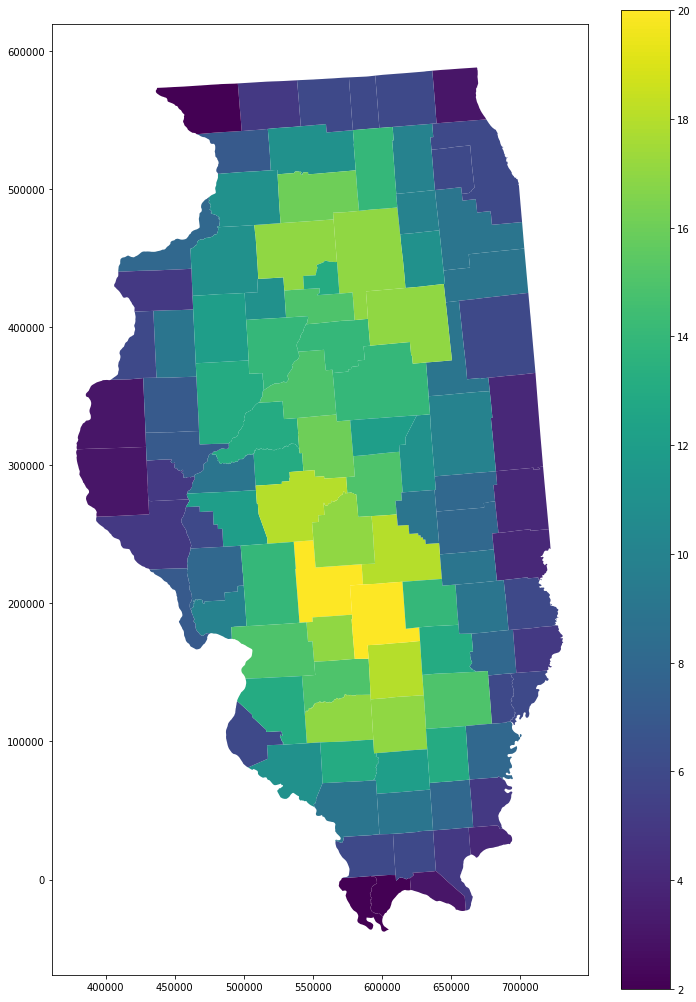

In [19]:
secondary_regions = viz_nregions(region2cu, county_shapefiles, PARAMS["graphml"]["geo_unit_key"])
secondary_regions.plot(column='nregions', figsize=PARAMS["output"]["figsize"], legend=True)

<hr id="memory">

# Merging by Memory

Now that we have done merging by set relations, further merges may increase the overall memory requirements so we have to consider memory usage from now on. Below are three functions that help us do that:

In [20]:
def calculate_memory_usage(memory_df: pd.DataFrame, memory_key: str, memory_col: str, list_of_ids: List[str]) -> Number:
    """
    Calculates the memory usage the shapefiles specified by a list of ids.

    Args:
        memory_df: DataFrame mapping memory_key to memory_col (spatial unit ID -> memory usage)
        memory_key: str, key/ID in memory_df
        memory_col: str, amount of memory usaged by data in spatial unit
        list_of_ids: list of str, ids to sum memory usage for

    Returns:
        Number, sum of memory usages for all ids
    """
    return sum([float(memory_df.loc[(memory_df[memory_key] == _id), memory_col]) for _id in list_of_ids])


def calculate_memory_difference(memory_df: pd.DataFrame, memory_key: str, memory_col: str, set_a: Iterable[str], set_b: Iterable[str]) -> Number:
    """
    Calculates the memory usage of the difference between two iterables of spatial unit IDs.

    Args:
        memory_df: DataFrame mapping memory_key to memory_col (spatial unit ID -> memory usage)
        memory_key: str, key/ID in memory_df
        memory_col: str, amount of memory usaged by data in spatial unit
        set_a: iterable of spatial units to subtract from
        set_b: iterable of spatial units to subtract

    Returns:
        Number, memory usage of A - B
    """
    set_a, set_b = set(set_a), set(set_b)
    _diff = set_a.difference(set_b)
    return calculate_memory_usage(memory_df, memory_key, memory_col, _diff)


def get_max_memory_usage(memory_df: pd.DataFrame, memory_key: str, memory_col: str, region2sudict: dict) -> Number:
    """
    Calculates the maximum memory requirement for all secondary regions.

    Args:
        memory_df: DataFrame mapping memory_key to memory_col (spatial unit ID -> memory usage)
        memory_key: str, key/ID in memory_df
        memory_col: str, amount of memory usaged by data in spatial unit
        region2sudict: dict, dictionary mapping (resource -> spatial units)

    Returns:
        float, maximum memory usage for a set of regions
    """
    return max([calculate_memory_usage(memory_df, memory_key, memory_col, region2sudict[key]) for key in region2sudict.keys()])


While we are operating under memory limits, the memory limit is not feasible unless we can load all secondary regions within the limit. Why? 

Because secondary regions are by design the set of counties required for *at least one* hospital corresponding to that region. So if our memory limit can't handle that set of counties, we can't calculate that hospital's travel-time catchment within the memory limit.

With that in mind, let's see the maximum memory usage for the current regions:

In [21]:
memory_usage_so_far = get_max_memory_usage(memory_df, 
                                           PARAMS["graphml"]["memory_key"],
                                           PARAMS["graphml"]["memory_column"],
                                           region2cu)
print(memory_usage_so_far)

5.0773770240000005


The next line asserts that our memory limit is greater than our current memory usage:

In [22]:
assert memory_usage_so_far < PARAMS["compute"]["max_memory"]

Now that we have passed that bar, we can start merging our regions by memory usage. This uses a greedy algorithm which combined regions with the smallest memory difference until no more merges can be made. This uses the following functions:

In [23]:
def merge_regions(region_a, region_b, region_to_census_units_dict, resource_to_region_dict):
    """
    Merge two regions in the region_to_census_units_dict and resource->region dict (res2reg_dict)

    Args:
        region_a: id of region
        region_b: id of region
        region_to_census_units_dict: dictionary of regions -> census units
        resource_to_region_dict: dictionary of resource -> region
        
    Returns:
        tuple of dicts: (updated region_to_census_units_dict, updated resource_to_region_dict)
    """
    region_to_census_units_dict[region_a] = region_to_census_units_dict[region_a].union(region_to_census_units_dict[region_b])
    del region_to_census_units_dict[region_b]
    # set resources to region_a
    region_b_resources = [key for key, item in resource_to_region_dict.items() if item == region_b]
    for resource in region_b_resources:
        resource_to_region_dict[resource] = region_a
    return region_to_census_units_dict, resource_to_region_dict


def regions_disjoint(region2sudict: dict, region_a: str, region_b: str) -> bool:
    """
    Tests if two regions are disjoint.

    Args:
        region2sudict: dictionary of regions -> spatial units
        region_a: id of a region
        region_b: id of a region

    Returns:
        boolean, if the set of file ids (counties) is disjoint
    """
    return set(region2sudict[region_a]).isdisjoint(region2sudict[region_b])


def minimum_combined_memory_region(memory_df: pd.DataFrame, memory_key: str, memory_col: str,
                                   region2sudict: dict, region_a: str) -> Tuple[Number, str, str]:
    """
    Finds the region (_to_merge_b) that minimizes the combined memory of region_a and _to_merge_b.

    Args:
        memory_df: Dataframe that maps region id to memory usage
        memory_key: key/ID to memory_df
        memory_col: field in memory_df with memory usage
        region2sudict: dictionary from region id -> list of file ids (counties)
        region_a: id of a region

    Returns:
        tuple: (float: memory usage, region_a, id of region that has minimum memory difference)
    """
    regions = list(region2sudict.keys())
    region_a_mem = calculate_memory_usage(memory_df, memory_key, memory_col, region2sudict[region_a])
    _merge_mem, _to_merge_b = 1000000000, -1
    for region_b in regions:
        if region_a != region_b and not regions_disjoint(region2sudict, region_a, region_b):
            _mem_diff = calculate_memory_difference(memory_df, memory_key, memory_col,
                                                    region2sudict[region_b], region2sudict[region_a])
            if _mem_diff < _merge_mem:
                _merge_mem, _to_merge_b = _mem_diff, region_b
    return (float(_merge_mem + region_a_mem), region_a, _to_merge_b)


def calculate_final_regions(region2sudict: dict, resource2regiondict: dict,
                            max_mem: Number, threads: int, memory_df: pd.DataFrame,
                            memory_key: str, memory_col: str, verbose: bool = False) -> Tuple[dict, dict]:
    """
    Calculates final regions by combining regions by memory usage.

    Args:
        region2sudict: dictionary of regions -> spatial units
        resource2regiondict: dictionary of resource -> region
        max_mem: memory usage not to exceed
        threads: how many threads to use when finding minimum_combined_memory_region for each region
        memory_df: Dataframe that maps region id to memory usage
        memory_key: key/ID to memory_df
        memory_col: field in memory_df with memory usage
        verbose (bool): whether or not to print all merges

    Returns:
        tuple of dicts, (updated region2sudict, updated resource2regiondict)

    Raises:
        assertion that max_mem is greater than required memory usage
    """
    initial_number_of_regions = len(region2sudict)
    how_many_chars = 12  # how many characters of region id to print
    loop_counter = 0  # keep track of how many outer loops
    done_combining = False
    while not done_combining:
        regions = list(region2sudict.keys())
        _start = time.time()  # for timing each iteration
        with mp.Pool(processes=threads) as pool:
            # calculate minimum combined memory region in parallel
            results = pool.starmap(minimum_combined_memory_region, zip(itertools.repeat(memory_df),
                                                                       itertools.repeat(memory_key),
                                                                       itertools.repeat(memory_col),
                                                                       itertools.repeat(region2sudict),
                                                                       regions))
        results = sorted(results, key=lambda tup: tup[0])  # sort by first element of tuple
        nmerged = 0  # number of mergers this iteration
        merged_this_iter = set()  # keep track of regions we have merged with this iteration
        if results[0][0] > max_mem:  # all merges are too big
            done_combining = True
        for _merge_mem, _to_merge_a, _to_merge_b in results:
            # memory is under the limit, the regions haven't been altered this run
            if _merge_mem <= max_mem and _to_merge_a not in merged_this_iter and _to_merge_b not in merged_this_iter:
                if verbose:
                    print("  New size: {:6.2f}, A: {}, B: {}".format(_merge_mem,
                                                                    str(_to_merge_a).ljust(how_many_chars)[:how_many_chars],
                                                                    str(_to_merge_b).ljust(how_many_chars)[:how_many_chars]))
                nmerged += 1
                merged_this_iter.add(_to_merge_a)
                merged_this_iter.add(_to_merge_b)
                region2sudict, resource2regiondict = merge_regions(_to_merge_a, _to_merge_b, region2sudict, resource2regiondict)
            elif _merge_mem > max_mem:
                break
        print(f"(Iter: {loop_counter}) Time: {time.time() - _start:4.2f}, Merged {nmerged} regions")
        loop_counter += 1
    _dropped = initial_number_of_regions - len(region2sudict)
    print(f"Dropped {_dropped} regions ({initial_number_of_regions}--->{len(region2sudict)})")
    return copy.deepcopy(region2sudict), copy.deepcopy(resource2regiondict)

This can take a little while, but each iteration should be faster than the last:

In [24]:
region2cu, resource2region = calculate_final_regions(region2cu,
                                                     resource2region,
                                                     PARAMS["compute"]["max_memory"],
                                                     PARAMS["compute"]["threads"],
                                                     memory_df,
                                                     PARAMS["graphml"]["memory_key"],
                                                     PARAMS["graphml"]["memory_column"])

(Iter: 0) Time: 2.95, Merged 26 regions
(Iter: 1) Time: 1.46, Merged 13 regions
(Iter: 2) Time: 1.17, Merged 11 regions
(Iter: 3) Time: 0.87, Merged 6 regions
(Iter: 4) Time: 0.66, Merged 3 regions
(Iter: 5) Time: 0.50, Merged 3 regions
(Iter: 6) Time: 0.41, Merged 2 regions
(Iter: 7) Time: 0.25, Merged 1 regions
(Iter: 8) Time: 0.30, Merged 0 regions
Dropped 65 regions (67--->2)


Let's again plot how many times each county is loaded with our final regions:

<AxesSubplot:>

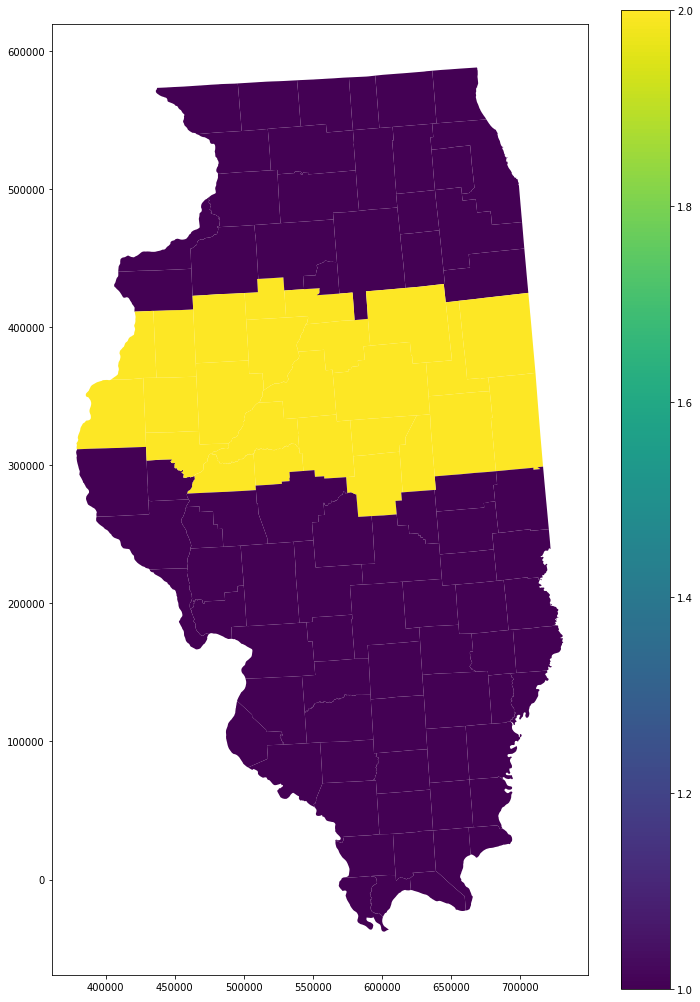

In [25]:
final_regions = viz_nregions(region2cu, county_shapefiles, PARAMS["graphml"]["geo_unit_key"])
final_regions.plot(column='nregions', figsize=PARAMS["output"]["figsize"], legend=True)

We can also visualize what these regions look like:

In [26]:
def viz_region_per_spatial_unit(region2sudict: dict, spatial_units: gpd.GeoDataFrame,
                                su_key: str, output_column: str = "region", nregions_column="nregions") -> gpd.GeoDataFrame:
    """
    Plots the spatial units colored according to the region (or multiple) they are in.

    Args:
        region2sudict: dictionary mapping regions to the spatial units within it
        spatial_units: GeoDataFrame of spatial units
        su_key: str, key for the spatial_units GeoDataFrame
        output_column: str, column to write result to
        nregions_column: output column for the number of regions each spatial unit is in (`viz_nregions`)

    Returns:
        copy of spatial units with `column` having the region (or multiple) each spatial unit is in
    """
    inverted_region_dict = dict()
    for region_num, (region, counties) in enumerate(region2sudict.items()):
        for county in counties:
            inverted_region_dict[county] = f"Region {region_num}"
    output_gdf = viz_nregions(region2sudict, spatial_units, su_key, output_column=nregions_column)
    # drop our output column if it already exists
    output_gdf = output_gdf.drop(columns=output_column, errors='ignore')
    output_gdf = output_gdf.merge(pd.DataFrame(inverted_region_dict.items(), columns=[su_key, output_column]), how="left", on=su_key)
    output_gdf.loc[output_gdf[nregions_column] > 1, output_column] = "Multiple"
    return output_gdf

In [27]:
final_regions = viz_region_per_spatial_unit(region2cu, county_shapefiles, PARAMS["graphml"]["geo_unit_key"])
final_regions.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,nregions,region
0,17,091,00424247,0500000US17091,17091,Kankakee,06,1752121058,12440760,"POLYGON ((644807.679 431295.144, 645687.311 43...",1,Region 1
1,17,187,01785134,0500000US17187,17187,Warren,06,1404747944,1674135,"POLYGON ((436783.276 363512.862, 436755.241 36...",2,Multiple
2,17,197,01785190,0500000US17197,17197,Will,06,2164927644,34548925,"POLYGON ((638438.260 499329.590, 638973.311 49...",1,Region 1
3,17,027,00424215,0500000US17027,17027,Clinton,06,1227664369,75635324,"POLYGON ((542119.643 147413.564, 543761.494 14...",1,Region 0
4,17,031,01784766,0500000US17031,17031,Cook,06,2447370818,1786313044,"POLYGON ((635130.213 537472.688, 635563.062 53...",1,Region 1


<AxesSubplot:>

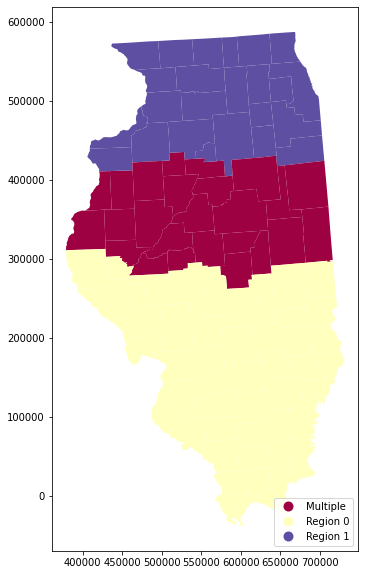

In [28]:
final_regions.plot(column='region', 
                   categorical=True, 
                   cmap='Spectral', 
                   figsize=(18,10),
                   legend=True, 
                   legend_kwds={'loc': 'lower right'})

In [29]:
primary_regions["logcount"] = np.log(primary_regions["nregions"])
secondary_regions["logcount"] = np.log(secondary_regions["nregions"])
final_regions["logcount"] = np.log(final_regions["nregions"])

In [30]:
cbfont_size = 14
font_size = 24
size = (12, 16)
wspace = 0
hspace = 0.07
fontfamily = "TeX Gyre Termes Math"
_colormap = 'RdYlBu'
edgecolor="black"
null_color='grey'
plt.rcParams.update({'font.size': font_size, 'font.family': fontfamily})

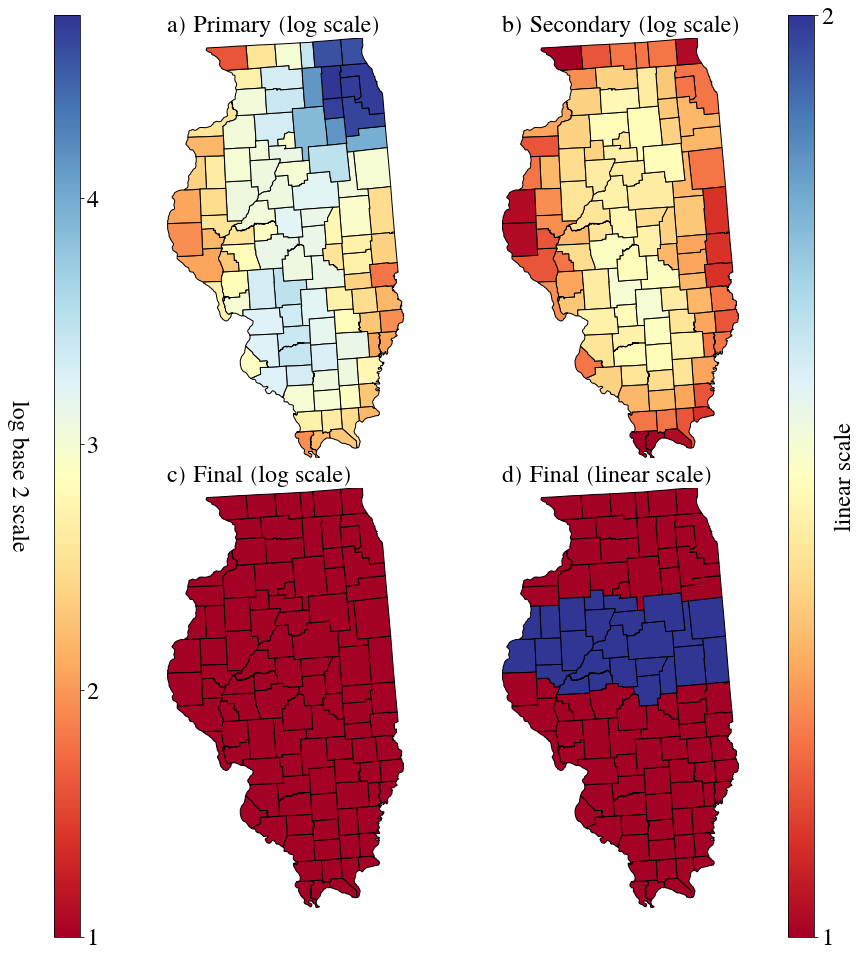

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=size)
for a in axes.flat:
    a.set_xticklabels([])
    a.set_yticklabels([])
    a.set_axis_off()
    a.margins(x=0, y=0)
fig.subplots_adjust(wspace=wspace, hspace=hspace)
#fig.suptitle("Clusters Per County")

vmax = max(primary_regions["logcount"])
vmin = 1
finalvmax = max(final_regions["nregions"])

axes[0,0] = primary_regions.plot(column='logcount', cmap=_colormap, ax=axes[0,0], edgecolor=edgecolor, missing_kwds=dict(color=null_color), vmin=vmin, vmax=vmax)
axes[0,0].set_title("a) Primary (log scale)", fontfamily=fontfamily, fontsize=font_size, loc='left') # increase or decrease y as needed

axes[0,1] = secondary_regions.plot(column='logcount', cmap=_colormap, ax=axes[0,1], edgecolor=edgecolor, missing_kwds=dict(color=null_color), vmin=vmin, vmax=vmax)
axes[0,1].set_title("b) Secondary (log scale)", fontfamily=fontfamily, fontsize=font_size, loc='left') # increase or decrease y as needed

axes[1,0] = final_regions.plot(column='logcount', cmap=_colormap, ax=axes[1,0], edgecolor=edgecolor, missing_kwds=dict(color=null_color), vmin=vmin, vmax=vmax)
axes[1,0].set_title("c) Final (log scale)", fontfamily=fontfamily, fontsize=font_size, loc='left') # increase or decrease y as needed

#cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)

axes[1,1] = final_regions.plot(column='nregions', cmap=_colormap, ax=axes[1,1], edgecolor=edgecolor, missing_kwds=dict(color=null_color), vmin=vmin, vmax=finalvmax)
axes[1,1].set_title("d) Final (linear scale)", fontfamily=fontfamily, fontsize=font_size, loc='left') # increase or decrease y as needed

caxlog = fig.add_axes([0.05, 0.1, 0.03, 0.8])
smlog = plt.cm.ScalarMappable(cmap=_colormap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
smlog._A = []
ticks = list(range(math.floor(vmin), math.ceil(vmax + 1)))
cbarlog = fig.colorbar(smlog, cax=caxlog, ticks=ticks)
cbarlog.ax.set_yticklabels([str(x) for x in ticks])
cbarlog.set_label("log base 2 scale", labelpad=-70, rotation=270)
# cbarlogax = cbarlog.ax
# cbarlogax.text(-1.5, 2.5,"log scale", rotation=90)

caxlin = fig.add_axes([0.9, 0.1, 0.03, 0.8])
smlin = plt.cm.ScalarMappable(cmap=_colormap, norm=plt.Normalize(vmin=vmin, vmax=finalvmax))
smlin._A = []
ticks = list(range(math.floor(vmin), math.ceil(finalvmax + 1)))
cbarlin = fig.colorbar(smlin, cax=caxlin, ticks=ticks)
cbarlin.ax.set_yticklabels([str(x) for x in ticks])
cbarlin.set_label("linear scale", labelpad=2, rotation=90)
# cbarlinax = cbarlin.ax
# cbarlinax.text(3, 1.45,"linear scale", rotation=90)

fig.savefig(os.path.join(PARAMS["region"]["dir"], "ILClustering.png"), dpi=100, bbox_inches='tight')

Now that we have broken down our spatial extent into regions, we can calculate travel-time catchments. This can be a VERY time consuming process and requires OSMnx networks, so we recommend using a compute cluster. The steps are as follows:

* For each region, load and compose (networkx has this functionality) the counties.
  * For each hospital in the region, calculate the egocentric network around the nearest OSM node to the hospital. To convert this into a polygon, calculate the convex hull around the nodes.